# 1. Generate simulated signal

In [1]:
sample_number = 10000
test_size = 0.2
signal_length = 1024
Fs = 20480

# bear_para = {'N':9, 'd':7.94004,'D':39.0398, 'alpha':0, 'fr':60, 'mode':['inner', 'outer', 'ball'], 'one_side':True, 'sigma':0.3}
# gear_para = {'teeth_num':10, 'fr':60, 'mode':['local', 'distributed'], 'one_side':False, 'sigma':0.3}

# from data_prepare.Simulation import data_prepare
# Simulated_dataset = data_prepare(sample_number, test_size, signal_length, Fs, bear_para, gear_para)
# import joblib
# joblib.dump(Simulated_dataset, './data/Simulated_dataset.pkl')

# 2. Train different versions of NISTA-Net

In [3]:
# import os
# from models.NISTA_Net import NISTA_Net
# from parameter_setting import parse_arg
# from tools.Train_Models import train_model

# for active in ['ReLU', 'Soft']: # different activation functions 
#     for pool in ['Avg','Max']: # different pooling functions 
#             opt = parse_arg()
#             opt.n_epochs = 30
#             opt.data_path = r'./data/Simulated_dataset.pkl'
#             opt.n_class = 5
#             opt.active_type = active
#             opt.pool_type = pool

#             opt.project_name = os.path.join( '_'.join(['NISTA_Net', opt.data_path.split('/')[-1].replace('.pkl',''),  'unfoldings', str(opt.unfoldings), 
#                                                                 'DC',str(opt.direct_connect),opt.active_type, opt.pool_type]))

#             # build the model
#             model = NISTA_Net(opt)

#             # train the model
#             model,Acc_train,Acc_test = train_model(model,opt)

# 3. Check the accuracy

In simulations all versions of NISTA-Net can easily get 100% classification accuracy. But the Soft activation function and the Max pooling are more useful for feature extraction! See the visualization part!

# 4. Visualize features learned by NISTA-Net

In [4]:
# get the index of each type of fault signal
import os
import joblib
import torch
import numpy as np
from data_prepare.Simulation import norm
from models.NISTA_Net import NISTA_Net
from parameter_setting import parse_arg

dataset_path  = r'.\data\Simulated_dataset.pkl'
simulated_dataset = joblib.load(dataset_path)
k = 0
index_list = [np.where(simulated_dataset['test_label']==i)[0][k] for i in range(5)]
signal_list = [norm(simulated_dataset['test_gth_1d'][index].flatten()) for index in index_list]

# input the noisy signal to the model and try to reconstruct features
opt = parse_arg()
opt.data_path = dataset_path
for active in ['ReLU', 'Soft']:
    for pool in ['Avg','Max']:
        opt.active_type = active
        opt.pool_type = pool
        model = NISTA_Net(opt)
        model_path = os.path.join('results', '_'.join(['NISTA_Net', 'Simulated_dataset',  'unfoldings', str(opt.unfoldings),
                                                       'DC',str(opt.direct_connect),opt.active_type, opt.pool_type]), 'model','model_epo_030_acc_100.0000.pth')
        model.load_state_dict(torch.load(model_path,map_location='cpu'))
        for index in index_list:
            _, _, x_hat  = model.forward(torch.Tensor(simulated_dataset['test_1d'][index:index+1]), all_out = True)
            signal_list.append(x_hat.detach().numpy().flatten())

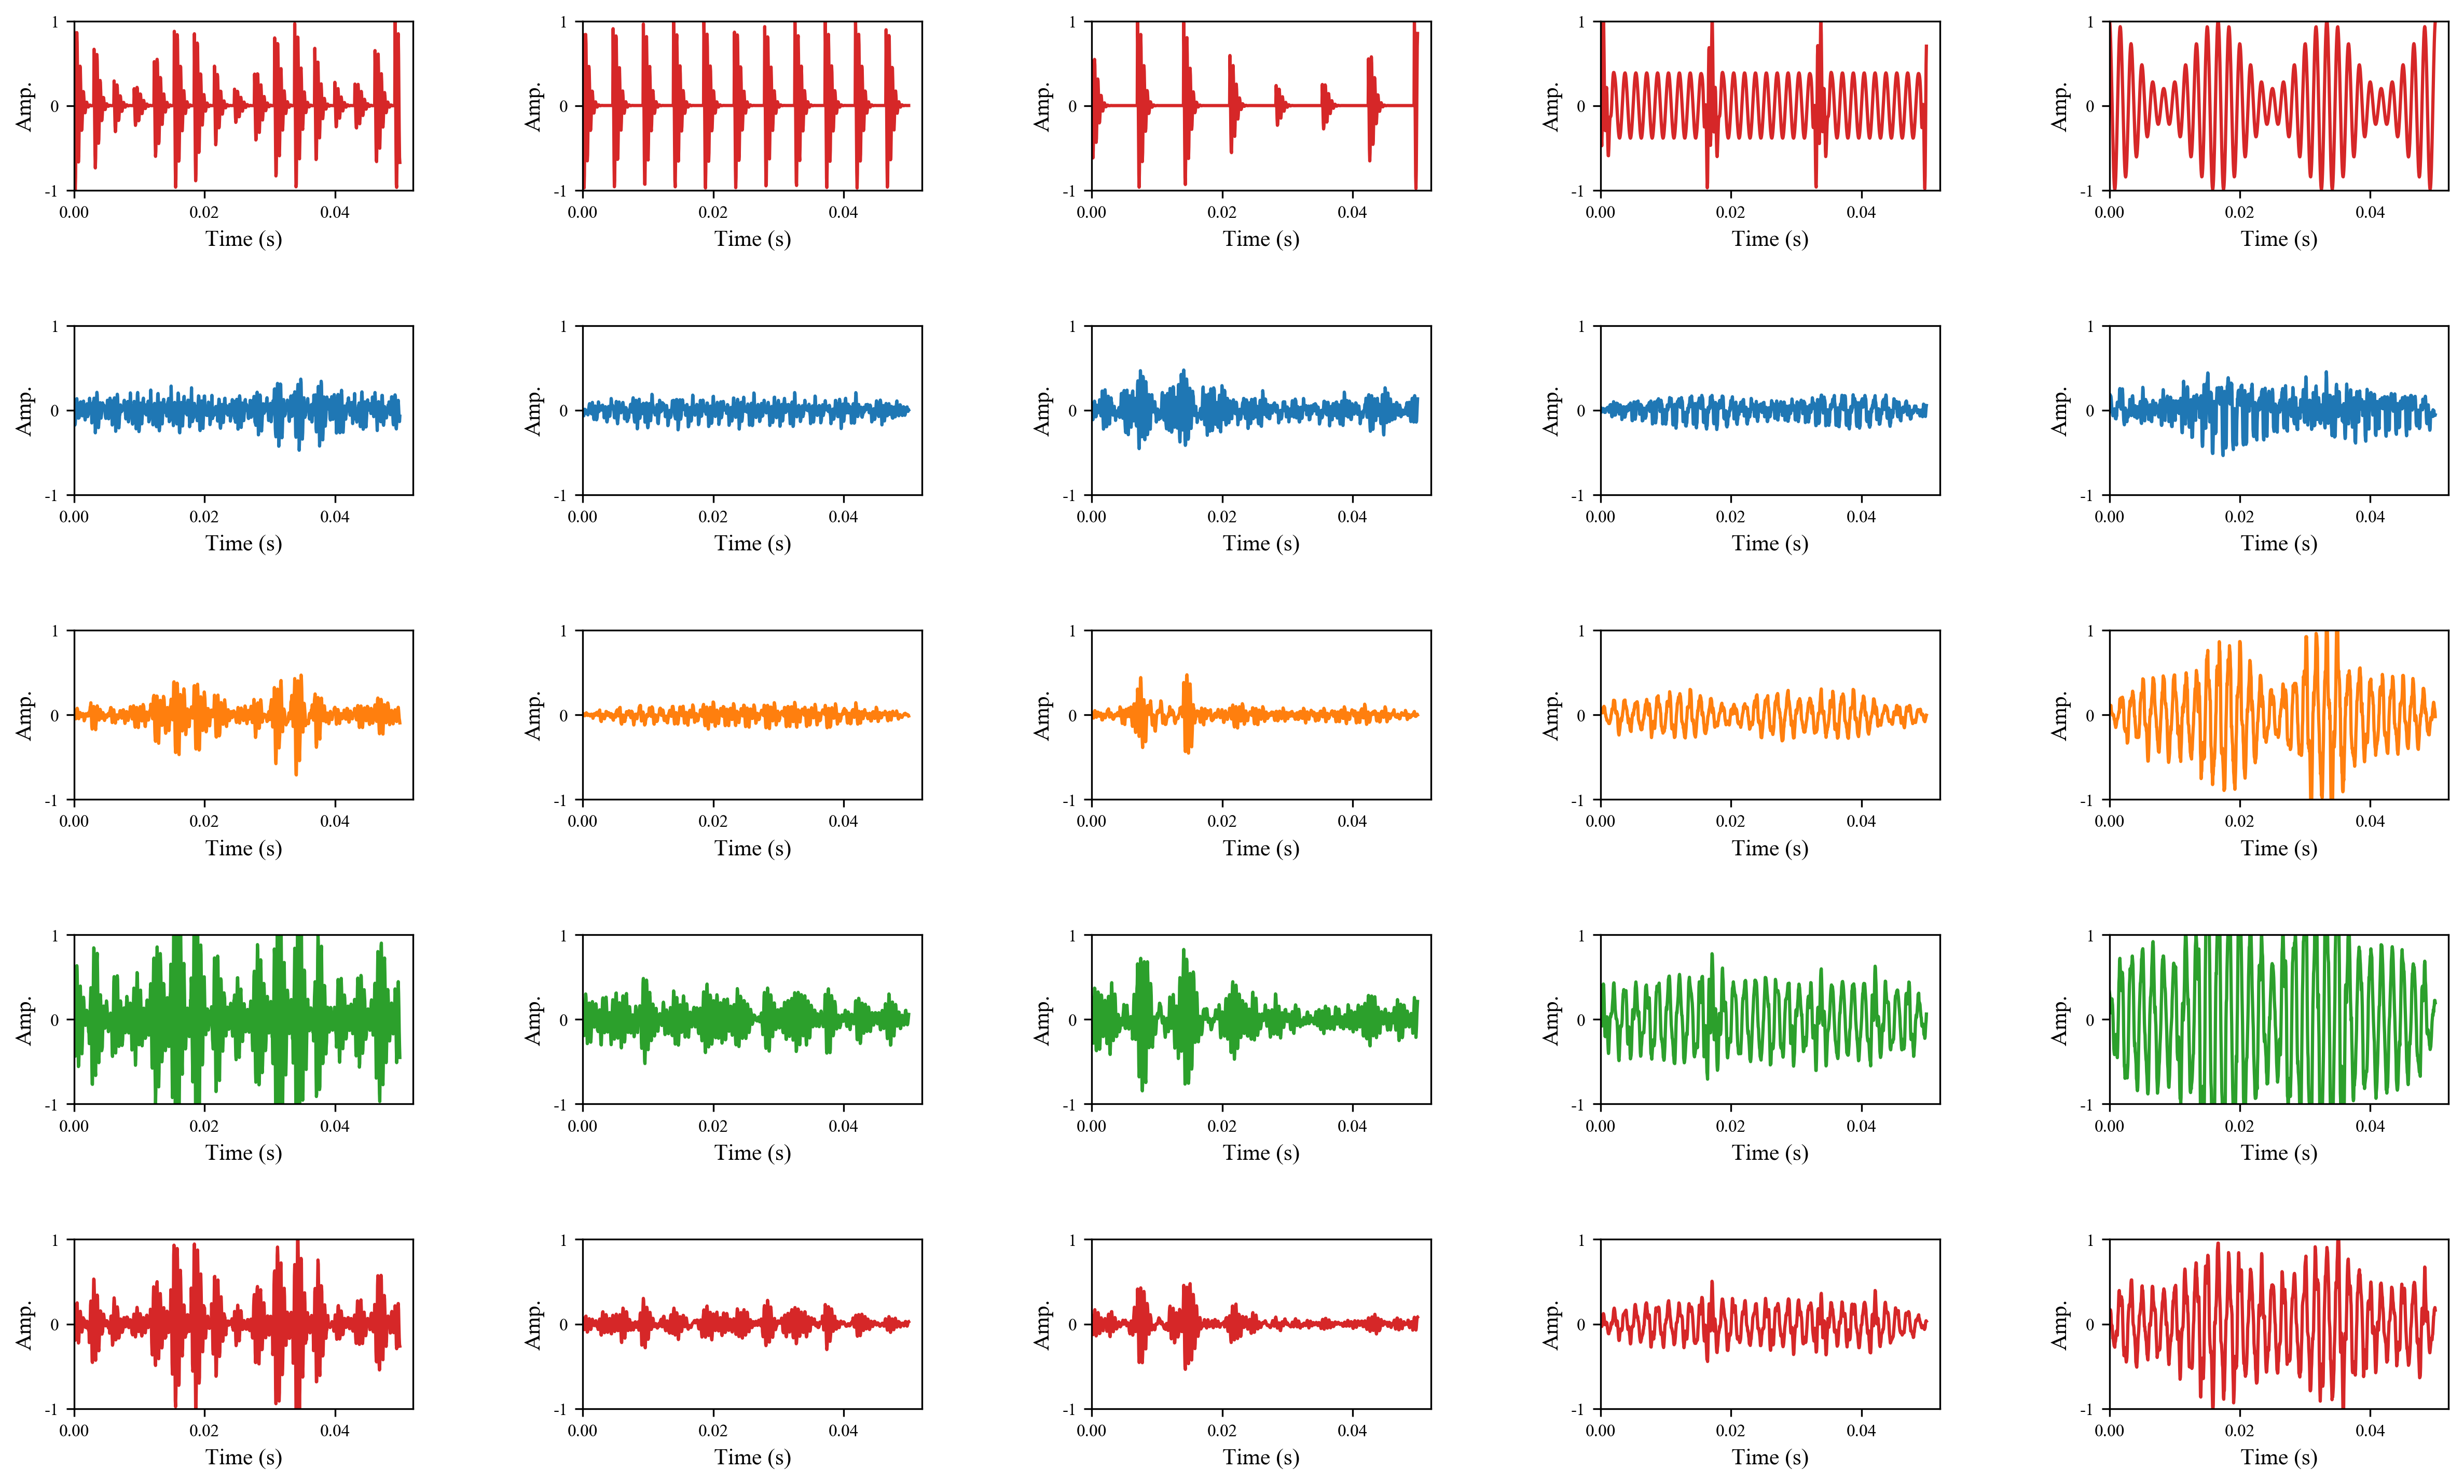

In [5]:
# plot the results
import matplotlib.pyplot as plt
from tools.get_color import default_color
from parameter_setting import plot_parameter
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
color_dict = default_color()
color_list = [color_dict['r'], color_dict['b'], color_dict['o'], color_dict['g'], color_dict['r']]

time= np.linspace(0,(signal_length-1)/Fs, signal_length)
figure = plot_parameter(1, [50, 30])
plt.subplots_adjust(wspace=0.5, hspace=0.8)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,i*5+j+1)
        plt.plot(time, signal_list[i*5+j], color=color_list[i], linewidth=1.5)
        plt.ylim([-1,1])
        plt.xlim([0,0.052])
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel('Time (s)')
        plt.ylabel('Amp.')
plt.show()